# Moving Average Crossover Strategy
Klasa Macs jest imlementacją obranej przez nas strategii.

Początkowa dane przechowywaliśmy w kolejkach FIFO (First in first out). Potrzebowaliśmy struktury o sługości równej oknu dłuższej średniej kroczącej, dane historyczne były zbędne.

In [ ]:
    def __init__(self, short_window, long_window):
        """ short_window - short window length
            long_window - long window length """
        self.price_ask = collections.deque(maxlen=long_window)
        self.long_window = long_window
        self.short_window = short_window
        self.last_signal = 0
        self.position = 0

Użyliśmy struktury *deque* z modułu collections. Zaletą tego rozwiązania jest to, że podczas dołączania nowych danych elementy nie są kopiowane. Po dołączeniu maksymalnej liczby elementów (*maxlen*) każdy nowy element zastępuje najstarszy element w kolejce.
Aby wygenerować raport końcowy potrzebne były nam jednak wszystkie dane, które pobraliśmy, więc zmieniliśmy kolejki FIFO na elementy *list*

In [ ]:
def __init__(self, short_window, long_window):
        """ short_window - short window length
            long_window - long window length """
        self.price = []
        self.long_window = long_window
        self.long_average = []
        self.short_window = short_window
        self.short_average = []
        self.last_signal = 0
        self.position = 0
        self.positions = []

Aby zaktualizować pobraną cenę dodajemy ją do listy.

In [ ]:
def update(self, ask):
        """ Update the price list and calculate strategy """
        self.price.append(ask)
        self.strategy()

Funkcja *calculate_windows()* oblicza obie średnie kroczące.

In [ ]:
def calculate_windows(self):
        """ Calculate long and short moving averages """
        _short = mean(self.price[-self.short_window:])
        _long = mean(self.price[-self.long_window:])
        self.short_average.append(_short)
        self.long_average.append(_long)
        return _short, _long

Funkcja *strategy()* generuje sygnały otwarcie i zamknięcia pozycji na podstawie dwóch ostatnich wartości obliczonych średnich.

In [ ]:
def strategy(self):
        """ Calculate buy/sell signals """
        if len(self.price) >= self.long_window:
            windows = self.calculate_windows()
            signal = 1 if windows[0] > windows[1] else 0
            self.position = signal - self.last_signal
            self.positions.append(self.position)
            self.last_signal = signal

Aby wygenerować raport dane sprowadzamy do *DataFrame'u* modułu *pandas*.

In [ ]:
df = pd.DataFrame(list(zip(*[self.price, self.short_average, self.long_average, self.positions])))
df.columns = ['Price', 'Short average', 'Long average', 'Positions']

Jest to struktura składająca się z wierszy i kolumn.

In [4]:
import pandas as pd
import pandas_datareader as pdr 
import numpy as np
import matplotlib.pyplot as plt 
import datetime

aapl = pdr.get_data_yahoo('AAPL', start=datetime.date(2012, 10, 1), end=datetime.date.today())

# Init. the short and long windows
short_window = 40
long_window = 100

# Init. the signals dataframe with  the signal column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create Short Simple Moving Average
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create Long Simple Moving Average
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

# Generate trading orders
signals['position'] = signals['signal'].diff()

print(aapl.head())
print(signals.head())

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2012-10-01  96.678574  93.785713  95.879997  94.198570  135898700.0  81.897568
2012-10-02  95.192856  92.949997  94.544289  94.472855  156998100.0  82.136055
2012-10-03  95.980003  94.661430  94.980003  95.921425  106070300.0  83.395477
2012-10-04  96.321426  95.078575  95.892860  95.257141   92681400.0  82.817886
2012-10-05  95.142860  93.040001  95.028572  93.227142  148501500.0  81.053017
            signal  short_mavg  long_mavg  position
Date                                               
2012-10-01     0.0   94.198570  94.198570       NaN
2012-10-02     0.0   94.335712  94.335712       0.0
2012-10-03     0.0   94.864283  94.864283       0.0
2012-10-04     0.0   94.962498  94.962498       0.0
2012-10-05     0.0   94.615427  94.615427       0.0


W naszej implementacji zapisujemy dane z *DataFrame* do pliku *csv*

In [ ]:
        df.to_csv(symbol+'.csv', index=False)

Do wygenerowania raportu używamy biblioteki *matplotlib*.

In [ ]:
        fig = plt.figure()
        ax1 = fig.add_subplot(111,  ylabel='Price')
        # Plot price
        df['Price'].plot(ax=ax1, color='r', lw=2.)
        # Plot both averages
        df[['Short average', 'Long average']].plot(ax=ax1, lw=2.)
        # Plot the buy signals
        ax1.plot(df.loc[df.Positions == 1.0].index, 
                df['Short average'][df['Positions'] == 1.0],
                '^', markersize=10, color='m')
        # Plot the sell signals
        ax1.plot(df.loc[df.Positions == -1.0].index, 
                df['Short average'][df['Positions'] == -1.0],
                'v', markersize=10, color='k')
        plt.title(symbol)
        plt.savefig(symbol+'.png')

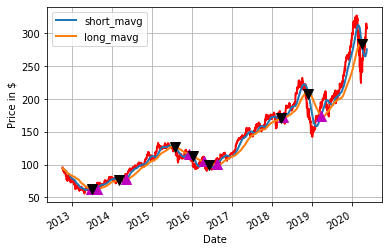

In [5]:
# Plot
# Init. the figure
fig = plt.figure()

# Add a subplot anad label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., grid=True)

# Plot the buy signals
ax1.plot(signals.loc[signals.position == 1.0].index, signals.short_mavg[signals.position == 1.0], '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals.loc[signals.position == -1.0].index, signals.short_mavg[signals.position == -1.0], 'v', markersize=10, color='k')

plt.show()